In [3]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import scipy.signal as signal
from google.colab import files

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
cd /content/drive/MyDrive/CIS5810/CIS_5810_Project_6_Poisson_Image_Editing_Student_Files_V2

/content/drive/MyDrive/CIS5810/CIS_5810_Project_6_Poisson_Image_Editing_Student_Files_V2


In [32]:
def getIndexes(mask, targetH, targetW, offsetX=0, offsetY=0):
    """
    Creates indexes of replacement area in the target image, each pixel in the
    replacement area gets index starting from 1, other pixels outside the
    replacement area get 0.

    Args:
    - mask: SrcH * SrcW, logical mask of source image
    - targetH, targetW: int, height and width of target image
    - offsetX, offsetY: int, offset of source image origin in the target image

    Return:
    - indexes: targetH * targetW, indexes of replacement area in target image
    """
    # IMPLEMENT HERE
    # you might find numpy.meshgrid and numpy.arange useful
    mask_H, mask_W = mask.shape
    mask_x, mask_y = np.meshgrid(np.arange(mask_W), np.arange(mask_H))
    indexes = np.zeros((targetH, targetW))

    target_x_coord = mask_x[mask>0]
    target_y_coord = mask_y[mask>0]


    target_x_coord += offsetX
    target_y_coord += offsetY

    indexes[target_y_coord, target_x_coord] = np.arange(1, target_x_coord.shape[0] + 1)

    return indexes

In [33]:
def getCoefficientMatrix(indexes):
    """
    Constructs the coefficient matrix (A in Ax=b)

    Args:
    - indexes: targetH * targetW, indexes of replacement area in target image

    Return:
    - A: N * N(N is max index), a matrix corresponds to laplacian kernel, 4 on the diagonal and -1 for each neighbor
    """
    # IMPLEMENT HERE
    # Since the coefficient matrix A is by nature sparse. Consider using scipy.sparse.csr_matrix to represent A to save space
    targetH, targetW = indexes.shape
    # A = 4 * np.eye(max(targetH, targetW))

    indexes_H, indexes_W = indexes.shape
    indexes_x, indexes_y = np.meshgrid(np.arange(indexes_W), np.arange(indexes_H))
    x = indexes_x[indexes > 0]
    y = indexes_y[indexes > 0]
    # A = 4 * np.eye(y.size)

    y_neighbor = np.arange(y.size)

    # Left neighbors
    left_y = y
    left_x = x - 1

    left_neighbor = indexes[left_y, left_x]

    left_y_neighbor = y_neighbor[left_neighbor > 0]
    left_x_neighbor = (left_neighbor[left_y_neighbor] - 1).astype(int)

    # right neighbors
    right_y = y
    right_x = x + 1

    right_neighbor = indexes[right_y, right_x]
    right_y_neighbor = y_neighbor[right_neighbor > 0]
    right_x_neighbor = (right_neighbor[right_y_neighbor] - 1).astype(int)

    # up neighbors
    up_y = y - 1
    up_x = x

    up_neighbor = indexes[up_y, up_x]
    up_y_neighbor = y_neighbor[up_neighbor > 0]
    up_x_neighbor = (up_neighbor[up_y_neighbor] - 1).astype(int)

    # down neighbors
    down_y = y + 1
    down_x = x

    down_neighbor = indexes[down_y, down_x]
    down_y_neighbor = y_neighbor[down_neighbor > 0]
    down_x_neighbor = (down_neighbor[down_y_neighbor] - 1).astype(int)

    #need to change A for last part?

    n = len(x)
    data = [4] * n + [-1] * (len(left_y_neighbor) + len(up_y_neighbor) + len(right_y_neighbor) + len(down_y_neighbor))
    row = np.concatenate((np.arange(n), left_y_neighbor, up_y_neighbor, right_y_neighbor, down_y_neighbor), axis=None)
    col = np.concatenate((np.arange(n), left_x_neighbor, up_x_neighbor, right_x_neighbor, down_x_neighbor), axis=None)

    A = sparse.csr_matrix((data, (row, col)), shape=(n, n))

    A[left_y_neighbor, left_x_neighbor] = -1
    A[right_y_neighbor, right_x_neighbor] = -1
    A[up_y_neighbor, up_x_neighbor] = -1
    A[down_y_neighbor,down_x_neighbor] = -1

    A = scipy.sparse.csr_matrix(A)
    return A

In [34]:
def getSolutionVect(indexes, source, target, offsetX, offsetY):
    """
    Constructs the target solution vector (b in Ax=b)

    Args:
    - indexes:  targetH * targetW, indexes of replacement area in target image
    - source, target: source and target image
    - offsetX, offsetY: int, offset of source image origin in the target image

    Returns:
    - solution vector b (for single channel)
    """
    # IMPLEMENT HERE
    # 1. get Laplacian part of b from source
    laplacian = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    source_laplacian = scipy.signal.convolve2d(source, laplacian, 'same')

    indexes_H, indexes_W = indexes.shape
    indexes_x, indexes_y = np.meshgrid(np.arange(indexes_W), np.arange(indexes_H))
    x = indexes_x[indexes > 0]
    y = indexes_y[indexes > 0]

    source_y = y - offsetY
    source_x = x - offsetX

    laplacian_b = source_laplacian[source_y, source_x]

    # 2. get pixel part of b from target image
    y_b = np.arange(x.shape[0])

    # Left neighbors
    left_y = y
    left_x = x - 1
    left_neighbor = indexes[left_y, left_x]

    left_y_zero = left_y[left_neighbor == 0]
    left_x_zero = left_x[left_neighbor == 0]
    left_val = target[left_y_zero, left_x_zero]
    left_b = np.zeros(x.shape[0])
    left_b[y_b[left_neighbor == 0]] = left_val

    # Right neighbors
    right_y = y
    right_x = x + 1

    right_neighbor = indexes[right_y, right_x]
    right_y_zero = right_y[right_neighbor == 0]
    right_x_zero = right_x[right_neighbor == 0]
    right_val = target[right_y_zero, right_x_zero]
    right_b = np.zeros(x.shape[0])
    right_b[y_b[right_neighbor == 0]] = right_val

    # Up neighbors
    up_y = y - 1
    up_x = x

    up_neighbor = indexes[up_y, up_x]
    up_y_zero = up_y[up_neighbor == 0]
    up_x_zero = up_x[up_neighbor == 0]
    up_val = target[up_y_zero, up_x_zero]
    up_b = np.zeros(x.shape[0])
    up_b[y_b[up_neighbor == 0]] = up_val

    # Down neighbors

    down_y = y + 1
    down_x = x

    down_neighbor = indexes[down_y, down_x]
    down_y_zero = down_y[down_neighbor == 0]
    down_x_zero = down_x[down_neighbor == 0]
    down_val = target[down_y_zero, down_x_zero]
    down_b = np.zeros(x.shape[0])
    down_b[y_b[down_neighbor == 0]] = down_val

    # 3. add two parts together to get b
    b = laplacian_b + left_b + right_b + up_b + down_b


    return b

In [35]:
def solveEqu(A, b):
    """
    Solve the equation Ax = b to get replacement pixels x in the replacement area
    Note: A is a sparse matrix, so we need to use corresponding function to solve it

    Args:
    - A: Laplacian coefficient matrix
    - b: target solution vector

    Returns:
    - x: solution of Ax = b
    """
    # IMPLEMENT HERE
    # you may find scipy.sparse.linalg.spsolve useful to solve equation

    x = scipy.sparse.linalg.spsolve(A, b)
    return x

In [36]:
def reconstructImg(indexes, red, green, blue, target):
    """
    Reconstruct the target image with new red, green, blue channel values in the
    indexes area

    Args:
    - indexes: targetH * targetW, indexes of replacement area in target image
    - red, green, blue: 1 x N, three chanels for replacement pixel values
    - target: target image

    Returns:
    - resultImg: reconstructed target image with poisson editing
    """
    # IMPLEMENT HERE
    # 1. get nonzero component in indexes
    non_zero_indices = np.where(indexes > 0)

    # 2. stack three channels together with numpy dstack
    replacement_pixels = np.dstack((red, green, blue))

    # 3. copy new pixels in the indexes area to the target image
    resultImg = np.copy(target)
    resultImg[non_zero_indices] = replacement_pixels

    return resultImg

### Seamless Cloning Poisson Editing

In [37]:
"""
Function (do not modify)
"""
def seamlessCloningPoisson(sourceImg, targetImg, mask, offsetX, offsetY):
    """
    Wrapper function to put all steps together

    Args:
    - sourceImg, targetImg: source and targe image
    - mask: logical mask of source image
    - offsetX, offsetY: offset of source image origin in the target image

    Returns:
    - ResultImg: result image
    """
    # step 1: index replacement pixels
    indexes = getIndexes(mask, targetImg.shape[0], targetImg.shape[1], offsetX,
                         offsetY)
    # step 2: compute the Laplacian matrix A
    A = getCoefficientMatrix(indexes)

    # step 3: for each color channel, compute the solution vector b
    red, green, blue = [
        getSolutionVect(indexes, sourceImg[:, :, i], targetImg[:, :, i],
                        offsetX, offsetY).T for i in range(3)
    ]

    # step 4: solve for the equation Ax = b to get the new pixels in the replacement area
    new_red, new_green, new_blue = [
        solveEqu(A, channel)
        for channel in [red, green, blue]
    ]

    # step 5: reconstruct the image with new color channel
    resultImg = reconstructImg(indexes, new_red, new_green, new_blue,
                               targetImg)
    return resultImg

461
614


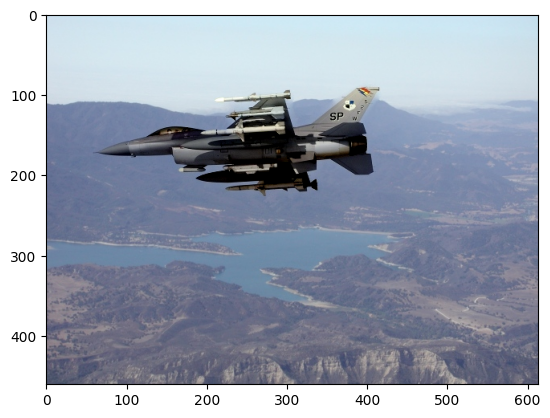

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
"""
Script (do not modify)
"""
src_path = 'Images/source_3.jpg'
src = np.array(Image.open(src_path).convert('RGB'), 'f') / 255
target_path  ='Images/target_3.jpg'
target = np.array(Image.open(target_path).convert('RGB'), 'f') / 255
offsetX = 40
offsetY = 20
mask_path = 'Images/mask_3.bmp'
mask = np.array(Image.open(mask_path)) > 0
result = seamlessCloningPoisson(src, target, mask, offsetX, offsetY)
plt.imshow(result)
plt.show()
cloned = Image.fromarray((np.clip(result, 0, 1) * 255).astype(np.uint8))
cloned.save('cloned.png')
files.download('cloned.png')

### Mixing gradient Poisson Editing

In [39]:
def getSolutionVectMixing(indexes, source, target, offsetX, offsetY):
    """
    Constructs the target solution vector(b in Ax=b)

    Args:
    - indexes:  targetH * targetW, indexes of replacement area
    - source, target: source and target image
    - offsetX, offsetY: offset of source image origin in the target image

    Returns:
    - solution vector b (for single channel)
    """
    # IMPLEMENT HERE
    # almost the same as getSolutionVect, need to change the Laplacian part of b
    laplacian = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    source_laplacian = scipy.signal.convolve2d(source, laplacian, 'same')
    target_laplacian = scipy.signal.convolve2d(target, laplacian, 'same')

    indexes_H, indexes_W = indexes.shape
    indexes_x, indexes_y = np.meshgrid(np.arange(indexes_W), np.arange(indexes_H))
    x = indexes_x[indexes > 0]
    y = indexes_y[indexes > 0]

    source_y = y - offsetY
    source_x = x - offsetX

    laplacian_b_source = source_laplacian[source_y, source_x]
    laplacian_b_target = target_laplacian[y, x]
    laplacian_b = np.where(abs(laplacian_b_source) >= abs(laplacian_b_target), laplacian_b_source, laplacian_b_target)

    # 2. get pixel part of b from target image
    y_b = np.arange(x.shape[0])

    # Left neighbors
    left_y = y
    left_x = x - 1
    left_neighbor = indexes[left_y, left_x]

    left_y_zero = left_y[left_neighbor == 0]
    left_x_zero = left_x[left_neighbor == 0]
    left_val = target[left_y_zero, left_x_zero]
    left_b = np.zeros(x.shape[0])
    left_b[y_b[left_neighbor == 0]] = left_val

    # Right neighbors
    right_y = y
    right_x = x + 1

    right_neighbor = indexes[right_y, right_x]
    right_y_zero = right_y[right_neighbor == 0]
    right_x_zero = right_x[right_neighbor == 0]
    right_val = target[right_y_zero, right_x_zero]
    right_b = np.zeros(x.shape[0])
    right_b[y_b[right_neighbor == 0]] = right_val

    # Up neighbors
    up_y = y - 1
    up_x = x

    up_neighbor = indexes[up_y, up_x]
    up_y_zero = up_y[up_neighbor == 0]
    up_x_zero = up_x[up_neighbor == 0]
    up_val = target[up_y_zero, up_x_zero]
    up_b = np.zeros(x.shape[0])
    up_b[y_b[up_neighbor == 0]] = up_val

    # Down neighbors

    down_y = y + 1
    down_x = x

    down_neighbor = indexes[down_y, down_x]
    down_y_zero = down_y[down_neighbor == 0]
    down_x_zero = down_x[down_neighbor == 0]
    down_val = target[down_y_zero, down_x_zero]
    down_b = np.zeros(x.shape[0])
    down_b[y_b[down_neighbor == 0]] = down_val

    # 3. add two parts together to get b
    b = laplacian_b + left_b + right_b + up_b + down_b

    return b

In [40]:
"""
Function (do not modify)
"""
def PoissonMixing(sourceImg, targetImg, mask, offsetX, offsetY):
    """
    Wrapper function to put all steps together

    Args:
    - sourceImg, targetImg: source and target image
    - mask: logical mask of source image
    - offsetX, offsetY: offset of source image origin in the target image

    Returns:
    - ResultImg: result image
    """
    # step 1: index replacement pixels
    indexes = getIndexes(mask, targetImg.shape[0], targetImg.shape[1], offsetX,
                         offsetY)
    # step 2: compute the Laplacian matrix A
    A = getCoefficientMatrix(indexes)

    # step 3: for each color channel, compute the solution vector b
    red, green, blue = [
        getSolutionVectMixing(indexes, sourceImg[:, :, i], targetImg[:, :, i],
                        offsetX, offsetY).T for i in range(3)
    ]

    # step 4: solve for the equation Ax = b to get the new pixels in the replacement area
    new_red, new_green, new_blue = [
        solveEqu(A, channel)
        for channel in [red, green, blue]
    ]

    # step 5: reconstruct the image with new color channel
    resultImg = reconstructImg(indexes, new_red, new_green, new_blue,
                               targetImg)
    return resultImg

300
233


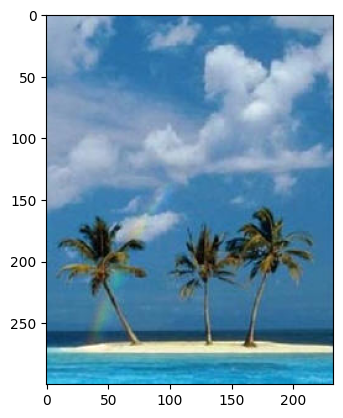

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
"""
Script (do not modify)
"""
src_path = 'Images/source_2.jpg'
src = Image.open(src_path).convert('RGB')

src = np.array(src, 'f') / 255
target_path  ='Images/target_2.jpg'
target = Image.open(target_path).convert('RGB')
target = np.array(target, 'f') / 255
offsetX = 10
offsetY = 130
mask_path = 'Images/mask_2.bmp'
mask = Image.open(mask_path)
mask =np.array(mask) > 0
result = PoissonMixing(src, target, mask, offsetX, offsetY)
plt.imshow(result)
plt.show()
mixed = Image.fromarray((np.clip(result, 0, 1) * 255).astype(np.uint8))
mixed.save('mixed.png')
files.download('mixed.png')

### Texture Flattening Poisson Editing

In [42]:
def getSolutionVectTexture(indexes, target, mask, edges):
    """
    Constructs the target solution vector(b in Ax=b)

    Args:
    - indexes:  targetH * targetW, indexes of replacement area
    - source, target: source and target image
    - offsetX, offsetY: offset of source image origin in the target image

    Returns:
    - solution vector b (for single channel)
    """
    # IMPLEMENT HERE
    # almost the same as getSolutionVect, need to change the Laplacian part of b

    laplacian = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])


    indexes_H, indexes_W = indexes.shape
    indexes_x, indexes_y = np.meshgrid(np.arange(indexes_W), np.arange(indexes_H))
    x = indexes_x[indexes > 0]
    y = indexes_y[indexes > 0]

    source_y = y - offsetY
    source_x = x - offsetX

    # get laplacian around the edges

    # laplacian_up
    # neighbors = (x-1, y), (x+1, y), (x, y-1), (x, y+1)
    b_up_diff = target[y, x] - target[y - 1, x]
    b_up = np.logical_or(edges[y, x], edges[y - 1, x])
    # b_up_edge = np.where(b_up_diff, b_up, 0)
    b_up_edge = np.where(b_up, b_up_diff, 0)

    # down
    b_down_diff = target[y, x] - target[y + 1, x]
    b_down = np.logical_or(edges[y, x], edges[y + 1, x])
    # b_down_edge = np.where(b_down_diff, b_down, 0)
    b_down_edge = np.where(b_down, b_down_diff, 0)

    # left
    b_left_diff = target[y, x] - target[y, x - 1]
    b_left = np.logical_or(edges[y, x], edges[y, x - 1])
    # b_left_edge = np.where(b_left_diff, b_left, 0)
    b_left_edge = np.where(b_left, b_left_diff, 0)

    # right
    b_right_diff = target[y, x] - target[y, x + 1]
    b_right = np.logical_or(edges[y, x], edges[y, x + 1])
    # b_right_edge = np.where(b_right_diff, b_right, 0)
    b_right_edge = np.where(b_right, b_right_diff, 0)

    laplacian_b = b_up_edge + b_down_edge + b_left_edge + b_right_edge

    # 2. get pixel part of b from target image
    y_b = np.arange(x.shape[0])

    # Left neighbors
    left_y = y
    left_x = x - 1
    left_neighbor = indexes[left_y, left_x]

    left_y_zero = left_y[left_neighbor == 0]
    left_x_zero = left_x[left_neighbor == 0]
    left_val = target[left_y_zero, left_x_zero]
    left_b = np.zeros(x.shape[0])
    left_b[y_b[left_neighbor == 0]] = left_val

    # Right neighbors
    right_y = y
    right_x = x + 1

    right_neighbor = indexes[right_y, right_x]
    right_y_zero = right_y[right_neighbor == 0]
    right_x_zero = right_x[right_neighbor == 0]
    right_val = target[right_y_zero, right_x_zero]
    right_b = np.zeros(x.shape[0])
    right_b[y_b[right_neighbor == 0]] = right_val

    # Up neighbors
    up_y = y - 1
    up_x = x

    up_neighbor = indexes[up_y, up_x]
    up_y_zero = up_y[up_neighbor == 0]
    up_x_zero = up_x[up_neighbor == 0]
    up_val = target[up_y_zero, up_x_zero]
    up_b = np.zeros(x.shape[0])
    up_b[y_b[up_neighbor == 0]] = up_val

    # Down neighbors

    down_y = y + 1
    down_x = x

    down_neighbor = indexes[down_y, down_x]
    down_y_zero = down_y[down_neighbor == 0]
    down_x_zero = down_x[down_neighbor == 0]
    down_val = target[down_y_zero, down_x_zero]
    down_b = np.zeros(x.shape[0])
    down_b[y_b[down_neighbor == 0]] = down_val

    solVectorb = laplacian_b + left_b + right_b + up_b + down_b

    return solVectorb

In [43]:
"""
Function (do not modify)
"""
def PoissonTextureFlattening(targetImg, mask, edges):
    """
    Wrapper function to put all steps together

    Args:
    - targetImg: target image
    - mask: logical mask of source image
    - offsetX, offsetY: offset of source image origin in the target image

    Returns:
    - ResultImg: result image
    """
    # step 1: index replacement pixels
    indexes = getIndexes(mask, targetImg.shape[0], targetImg.shape[1])
    # step 2: compute the Laplacian matrix A
    A = getCoefficientMatrix(indexes)

    # step 3: for each color channel, compute the solution vector b
    red, green, blue = [
        getSolutionVectTexture(indexes, targetImg[:, :, i], mask, edges).T for i in range(3)
    ]

    # step 4: solve for the equation Ax = b to get the new pixels in the replacement area
    new_red, new_green, new_blue = [
        solveEqu(A, channel)
        for channel in [red, green, blue]
    ]

    # step 5: reconstruct the image with new color channel
    resultImg = reconstructImg(indexes, new_red, new_green, new_blue,
                               targetImg)
    return resultImg

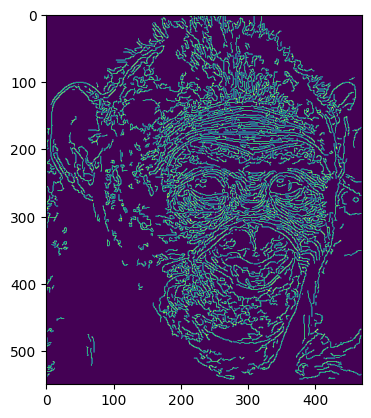

550
470


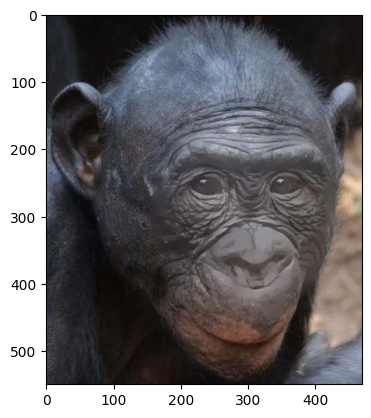

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
"""
Script (do not modify)
"""
target_path  ='Images/bonobo.jpg'
target = np.array(Image.open(target_path).convert('RGB'), 'f') / 255
from skimage.color import rgb2gray
from skimage import feature
edges = feature.canny(rgb2gray(target))
plt.imshow(edges)
plt.show()
mask_path = 'Images/mask_bonobo.bmp'
mask = np.array(Image.open(mask_path)) > 0
result = PoissonTextureFlattening(target, mask, edges)
plt.imshow(result)
plt.show()
flatten = Image.fromarray((np.clip(result, 0, 1) * 255).astype(np.uint8))
flatten.save('flatten.png')
files.download('flatten.png')